### Exercise 3 - Dynamic Programming and LQR

In this exercise, we will use dynamic programming (DP) to implement a controller for an inverted pendulum and compare it to a LQR control approach.

The pendulum position is described by the angle $\theta$ with corresponding angle velocity $\omega$ and we can control it by applying a torque $\tau$. This system can be described by idealized dynamics
\begin{equation}
\begin{aligned}
\dot{\theta} &= \omega, \\
\dot{\omega} &= \sin(\theta) + \tau,
\end{aligned}
\end{equation}
where for simplicity we are ignoring all units. Defining the state $s=(\theta, \omega)$, with control actions $a=\tau$, our control aim is to swing up the pendulum to the upright position and balancing it there, corresponding to a state of $s_\mathrm{ref}=(0,0)$. We start with the pendulum hanging down in a rest position, i.e., $\bar s_0 = (\pi, 0)$. We can express this as the discrete time optimal control problem:
<!-- \begin{mini}|s|[2]
{\scriptstyle{\substack{s_0, \dots, s_N, \\ a_0, \dots, a_{N-1}}}}
{
	\sum_{i=0}^{N-1}
	\left(\,s_i^TQs_i + a_i^TRa_i\right)
	+ 
	s_N^TQ_Ns_N,
}
{\label{eq:nlp}}
{}
\addConstraint{s_0}{= \bar{s}_0}
\addConstraint{s_{i+1}}{= F(s_i, a_i),}{~i = 0, \ldots, N-1}
\addConstraint{-10}{\leq a_i \leq 10,}{~i = 0, \ldots, N-1}
\addConstraint{-\frac{\pi}{2}}{\leq \theta_i \leq 2\pi,}{~i = 0, \ldots, N-1}
\addConstraint{-8}{\leq \omega_i \leq 8,}{~i = 0, \ldots, N-1,}
\end{mini} -->
<img src="imgs/nlp.png" alt="nlp" width="350"/>

where $F(s,a)$ describes the discretized dynamics obtained by applying one step of the explicit RK4 integrator with step-size $h=0.1$ to the continuous time system dynamics.

We choose $Q = \textrm{diag}(100,\, 0.01)$ and $R = 0.001$.

In [1]:
import numpy as np
from casadi import SX, vertcat, sin
from model import Model
from utils import integrate_RK4

# continuous dynamics
ns = 2   # dimension of the state
na = 1   # dimension of the controls

theta = SX.sym('theta')
omega = SX.sym('omega')
a = SX.sym('a')

theta_dot = omega
omega_dot = sin(theta) + a

s = vertcat(theta, omega)
s_dot = vertcat(theta_dot, omega_dot)

# discrete dynamics
dt = 0.1
n_steps = 5
F_discrete = integrate_RK4(s, a, s_dot, dt, n_steps)

# steady state
s_steady_state = np.zeros((ns, 1))
a_steady_state = np.zeros((na, 1))

model = Model(s, a, F_discrete, s_steady_state, a_steady_state)

### 3.1 LQR

Consider the unconstrained linear quadratic infinite horizon problem that is obtained from the above nonlinear optimization problem by linearizing the dynamics at $s_\mathrm{lin} = (0, 0)$, $a_\mathrm{lin} = 0$, and dropping the control constraints,
<!-- \begin{mini}|s|[2]
	{\scriptstyle{\substack{s_0, s_1, \dots, \\ a_0, a_1, \dots}}}
	{
		\sum_{i=0}^{\infty}
		\left(\,s_i^TQs_i + a_i^TRa_i\right)
	}
	{\label{eq:LQRqp}}
	{}
	\addConstraint{s_0}{= \bar{s}_0}
	\addConstraint{s_{i+1}}{= A s_i + B a_i,}{~i = 0, 1, \ldots, }
\end{mini} -->
<img src="imgs/qp.png" alt="nlp" width="280"/>

where $A:=\frac{\partial F(s,a)}{\partial s}\big\rvert_{\substack{s=s_\mathrm{lin} \\ a = a_\mathrm{lin}}}$ and $B:=\frac{\partial F(s,a)}{\partial a}\big\rvert_{\substack{s=s_\mathrm{lin} \\ a = a_\mathrm{lin}}}$.


Complete the following template to obtain the LQR gain matrix $K$, which defines the optimal control at each stage as the time-independent linear feedback law $a^*_i(s) = -K s$ and the solution to the associated Riccati equation $P$.

*Hint: Check out* `scipy.linalg.solve_discrete_are`




In [2]:
from scipy.linalg import solve_discrete_are

def get_LQR_gain(A, B, Q, R):

# FILL IN YOUR CODE HERE
    P = solve_discrete_are(A, B, Q, R)
    K = np.linalg.solve((B.T @ P @ B + R), B.T @ P @ A)
    return (K, P)

Use $P$ and $K$ to compute the LQR cost and control policy for all $s$ within the state grid. Discretize the angle $\theta$ into 101 values between $-\frac{\pi}{2}$ and $2\pi$. Analogously, discretize the angular velocity into 51 values between -8 and 8 and the torque $\tau$ into 21 values between 10 and -10. 

Don't forget to clip the controls to the given control bounds.

In [3]:
# discretize the state and control space
s_min = [-np.pi/2, -8]
s_max = [2*np.pi, 8]

a_max = 10
a_min = -a_max

N_s1 = 101
N_s2 = 51
N_a = 21

s1_grid = np.linspace(s_min[0], s_max[0], N_s1)
s2_grid = np.linspace(s_min[1], s_max[1], N_s2)
a_grid = np.linspace(a_min, a_max, N_a)

#  mesh for plotting
[S1, S2] = np.meshgrid(s1_grid, s2_grid)
S1 = S1.T
S2 = S2.T

In [4]:
# setup LQR: linearize at the steady state
# FILL IN YOUR CODE HERE
# HINT: check out the provided model class
A = model.J_x(np.zeros(ns), np.zeros(na))
B = model.J_u(np.zeros(ns), np.zeros(na))

# weighting matrices
Q = np.diag([100, 0.01])
R = np.diag([0.001])

(K, P) = get_LQR_gain(A, B, Q, R)

LQR_cost = np.zeros(S1.shape)  # grid with cost of every state combination
LQR_a = np.zeros(S1.shape)     # LQR control for every state combination

# loop through all state and input combinations
for i in range(S1.shape[0]):
    for j in range(S1.shape[1]):
        s = np.reshape(np.array([S1[i, j], S2[i, j]]), (ns, 1))

# FILL IN YOUR CODE HERE
        LQR_cost[i,j] = s.T @ P @ s
        LQR_a[i,j] = -K @ s

# FILL IN YOUR CODE HERE
# clipping
LQR_a = np.clip(LQR_a, a_min=a_min, a_max=a_max)

### 3.2 Dynamic Programming 

Complete the following template to implement the DP algorithm and use it to compute the cost-to-go associated with the initial state of the optimal control problem. Choose $N=20$, and use again $Q = \textrm{diag}(100,\, 0.01)$, $R = 0.001$ and $Q_N$ equal to the cost matrix associated with the LQR controller. We use the same discretization grid as for the LQR.

*Remark: In order to compute the cost-to-go we project the state obtained by simulating the dynamics forward onto the defined discretization grid and interpolate the cost-to-go value.*


In [5]:
from utils import project_indices
N_steps = 20

# precompute discrete simulation map
s_next_map = np.zeros((N_s1, N_s2, N_a, ns))

# precompute the projected indices
projected_indices_s1 = np.zeros((N_s1, N_s2, N_a, 2), dtype=np.int16)
projected_indices_s2 = np.zeros((N_s1, N_s2, N_a, 2), dtype=np.int16)

# loop through all state and input combinations
for i in range(S1.shape[0]):
    for j in range(S1.shape[1]):
        s = np.reshape(np.array([S1[i, j], S2[i, j]]), (ns, 1))

        # compute next state for all u
        for k in range(N_a):
            s_next = np.reshape(model.simulate(s, a_grid[k]), (ns,))
            s_next_map[i, j, k, :] = s_next

            # project s_next to the state grid
            projected_indices_s1[i,j,k, :] = project_indices(s_next[0], s1_grid)
            projected_indices_s2[i,j,k, :] = project_indices(s_next[1], s2_grid)

In [6]:
from math import inf
from utils import interpolate_bilinear

# initialization of cost-to-go function for all iterations with
# infinity until we know a better cost
dp_cost_to_go = inf*np.ones((S1.shape[0], S1.shape[1], N_steps+1))

# terminal cost is same as LQR
# FILL IN YOUR CODE HERE
dp_cost_to_go[:, :, 0] = LQR_cost.copy()

# compute cost-to-go of initial state via backward recursion
for k in range(N_steps):

    print("Step", k)

    # will contain optimal control input for every state
    dp_a = inf*np.ones((N_s1, N_s2))

    # loop through all state combinations
    for i1 in range(S1.shape[0]):
        for i2 in range(S1.shape[1]):

            s_current = np.reshape(np.array([S1[i1, i2], S2[i1, i2]]), (ns, 1))

            # loop through all control
            for j, a_current in enumerate(a_grid):

                # get next state for given current state and control
                s_next = s_next_map[i1, i2, j, :]

                # get indices of projected x values
                [ix1, ix2] = projected_indices_s1[i1,i2,j, :]
                [iy1, iy2] = projected_indices_s2[i1,i2,j, :]

                # if not outside the grid
                if not(ix1 < 0 or iy1 < 0 or ix2 >= N_s1 or iy2 >= N_s2):

                    J_val = interpolate_bilinear(s_next[0], s_next[1],
                             s1_grid[ix1], s2_grid[iy1], s1_grid[ix2], s2_grid[iy2],
                             dp_cost_to_go[ix1, iy1, k], dp_cost_to_go[ix1, iy2, k], dp_cost_to_go[ix2, iy1, k], dp_cost_to_go[ix2, iy2, k])

                    # cost of this control at this state
                    # FILL IN YOUR CODE HERE
                    cost = s_current.T @ Q @ s_current + a_current * R * a_current + J_val

                    if cost < dp_cost_to_go[i1,i2, k+1]:
                        # FILL IN YOUR CODE HERE
                        dp_cost_to_go[i1,i2, k+1] = cost
                        dp_a[i1,i2] = a_current

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19


### 3.3 Comparison LQR and DP

Consider the following plots showing the cost of DP and LQR as well as their control policies. Where is the LQR policy similar to the one obtained with DP? Where is it different? Why? 

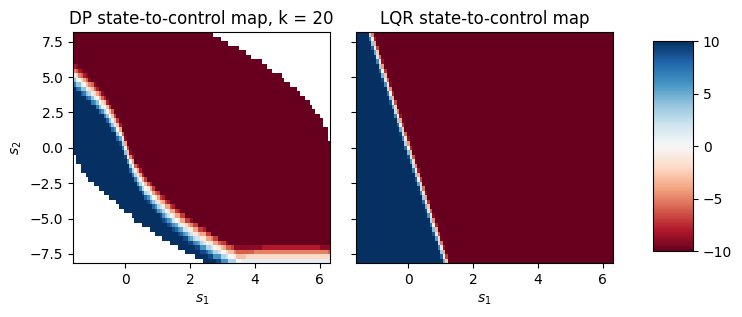

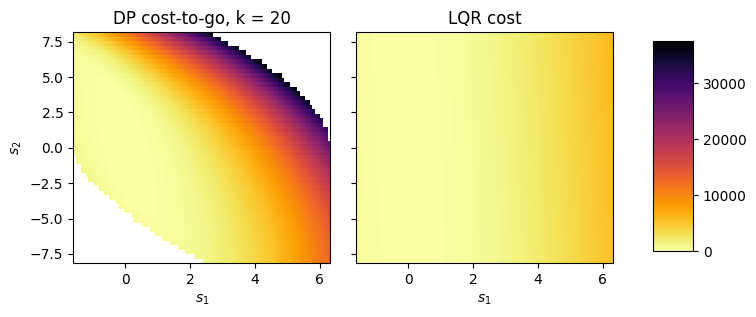

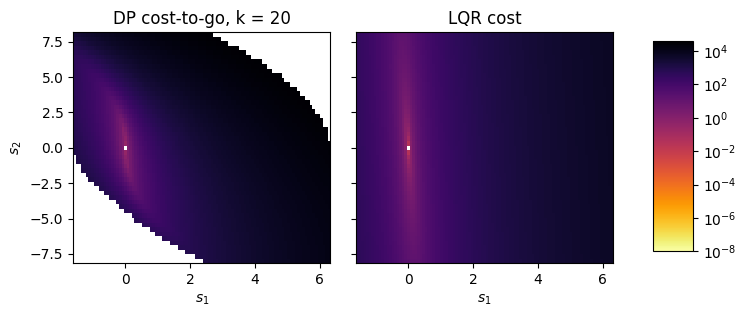

In [7]:
from plot_utils import *

# set inf values to nan so they are not shown in plot
J_final = dp_cost_to_go[:, :, -1]
J_final[J_final == inf] = np.nan

plot_control_maps(dp_a, LQR_a, S1, S2, N_steps, amin=a_min, amax=a_max)
plot_cost_maps(J_final, LQR_cost, S1, S2, N_steps, log_scale=False)
plot_cost_maps(J_final, LQR_cost, S1, S2, N_steps, log_scale=True)

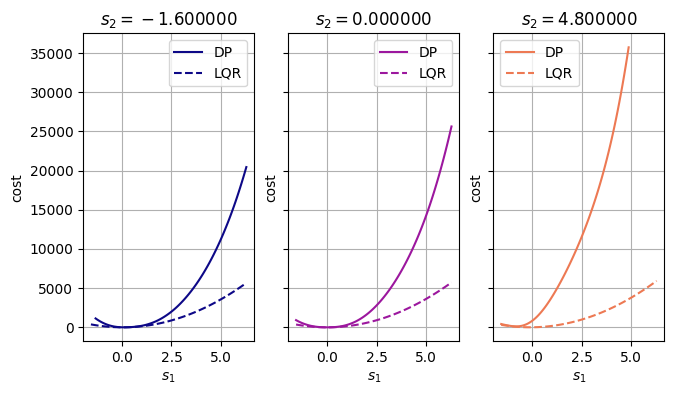

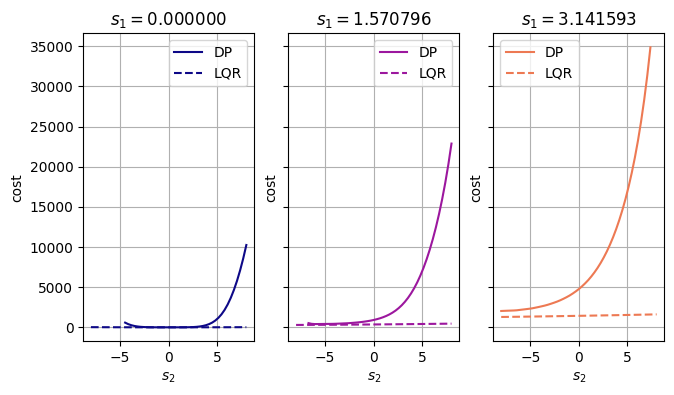

In [8]:
plot_indices_s2 = [20, 25, 40]
plot_cost_slices(J_final, LQR_cost, s1_grid, s2_grid, plot_indices_s2, vary_s1=True)

plot_indices_s1 = [20, 40, 60]
plot_cost_slices(J_final, LQR_cost, s1_grid, s2_grid, plot_indices_s1, vary_s1=False)